<a href="https://colab.research.google.com/github/ahkswarun/Fake-Currency-Detection-System-Using-Deep-Learning-and-MobileNetV3/blob/main/Fake_Currency_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle, class_weight
from tqdm import tqdm
import cv2
from collections import Counter
from torch.utils.data import DataLoader
from PIL import Image


In [ ]:
# Define labels

class_names = ['fifty fake', 'fifty original', 'five hundred fake', 'five hundred original',
               'hundred fake', 'hundred original', 'ten fake', 'ten original',
               'twenty fake', 'twenty original', 'two hundred fake', 'two hundred original',
               'two thousand fake', 'two thousand original']

class_names_label = {class_name: i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)
IMAGE_SIZE = (448,224) #(300,150)

In [ ]:
# Load and preprocess dataset
def load_data():
    datasets = [r"/content/drive/MyDrive/PJT 2/fake currency using CNN/dataset"]
    output = []

    for dataset in datasets:
        images = []
        labels = []

        print(f"Loading {dataset}")

        for folder in os.listdir(dataset):
            folder_path = os.path.join(dataset, folder)
            if not os.path.isdir(folder_path):
                continue

            if folder not in class_names_label:
                print(f"Warning: '{folder}' not found in class_names_label. Skipping.")
                continue

            label = class_names_label[folder]

            for file in tqdm(os.listdir(folder_path)):
                img_path = os.path.join(folder_path, file)
                try:
                    image = cv2.imread(img_path)
                    if image is None:
                        print(f"Warning: Failed to load image {img_path}. Skipping.")
                        continue

                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, IMAGE_SIZE)
                    images.append(image)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
                    continue

        images = np.array(images)
        labels = np.array(labels)
        output.append((images, labels))

    return output


In [ ]:
(train_images, train_labels), = load_data()

Loading /content/drive/MyDrive/PJT 2/fake currency using CNN/dataset


 90%|█████████ | 36/40 [00:37<00:04,  1.13s/it]

In [ ]:
# Shuffle training data
train_images, train_labels = shuffle(train_images, train_labels, random_state=100)

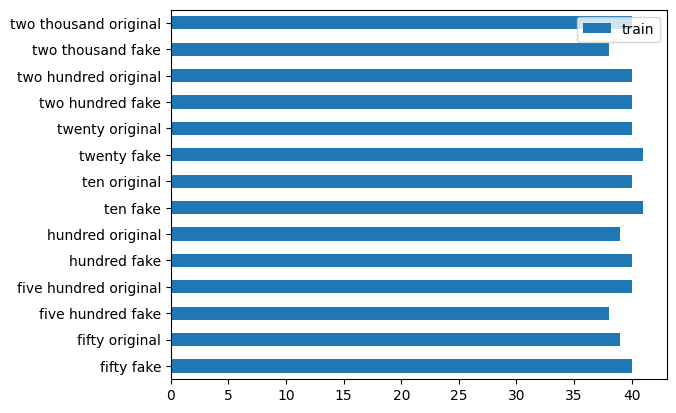

In [ ]:

_, train_counts = np.unique(train_labels, return_counts=True)
pd.DataFrame({'train': train_counts},index=class_names).plot.barh()
plt.show()

In [ ]:
# PyTorch Dataset Class
class CurrencyDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# Split into training (80%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=101)

In [ ]:
# Data Augmentation and Normalization
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop((224, 448)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])


test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Create Datasets and Dataloaders
train_dataset = CurrencyDataset(X_train, y_train, transform=train_transform)
val_dataset = CurrencyDataset(X_val, y_val, transform=test_transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Load Pretrained MobileNetV3 Model
model = models.mobilenet_v3_large(pretrained=True)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 14)  # 14 classes as per our dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=0.001)

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_train += labels.size(0)

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = running_corrects.double() / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc.item())

        model.eval()
        val_loss = 0.0
        val_corrects = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * images.size(0)
                val_corrects += torch.sum(preds == labels.data)
                total_val += labels.size(0)

        epoch_val_loss = val_loss / total_val
        epoch_val_acc = val_corrects.double() / total_val
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item())

        print(f'Epoch [{epoch + 1}/{num_epochs}]')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            model_save_path = '/content/drive/MyDrive/PJT 2/fake currency using CNN/best_model.pth'
            torch.save(model.state_dict(), model_save_path)
            print('✅ Best model saved!')

    print('Training Complete.')
    return history

# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 140MB/s]


Epoch [1/25]
Train Loss: 1.9301, Train Acc: 0.3671
Val Loss: 1.4464, Val Acc: 0.5268
✅ Best model saved!
Epoch [2/25]
Train Loss: 0.9010, Train Acc: 0.6959
Val Loss: 0.6799, Val Acc: 0.6786
✅ Best model saved!
Epoch [3/25]
Train Loss: 0.6494, Train Acc: 0.7432
Val Loss: 0.5738, Val Acc: 0.7589
✅ Best model saved!
Epoch [4/25]
Train Loss: 0.5428, Train Acc: 0.7995
Val Loss: 0.3890, Val Acc: 0.8214
✅ Best model saved!
Epoch [5/25]
Train Loss: 0.4631, Train Acc: 0.8176
Val Loss: 0.3586, Val Acc: 0.8750
✅ Best model saved!
Epoch [6/25]
Train Loss: 0.3728, Train Acc: 0.8491
Val Loss: 0.3396, Val Acc: 0.8125
Epoch [7/25]
Train Loss: 0.3329, Train Acc: 0.8851
Val Loss: 0.3894, Val Acc: 0.8482
Epoch [8/25]
Train Loss: 0.3254, Train Acc: 0.8851
Val Loss: 0.3017, Val Acc: 0.8661
Epoch [9/25]
Train Loss: 0.3320, Train Acc: 0.8716
Val Loss: 0.2479, Val Acc: 0.9196
✅ Best model saved!
Epoch [10/25]
Train Loss: 0.3201, Train Acc: 0.8716
Val Loss: 0.3218, Val Acc: 0.8661
Epoch [11/25]
Train Loss: 0.3

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/PJT 2/fake currency using CNN/best_model.pth')

Text(0.5, 1.0, 'Loss over Epochs')

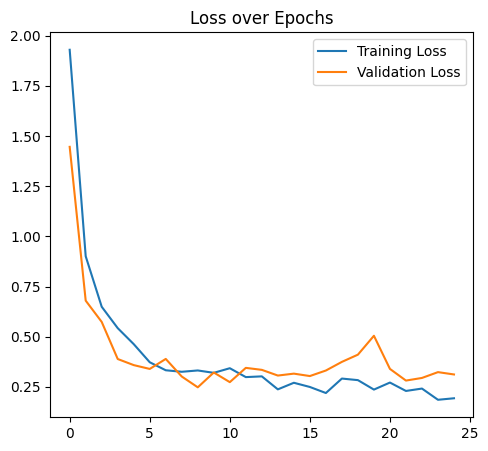

In [ ]:
# Plot Training Results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

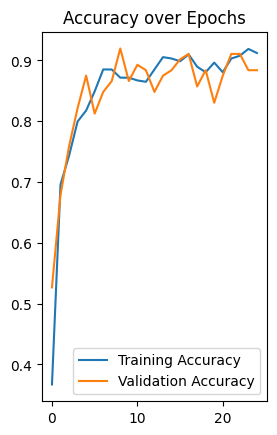

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

Validation Set Evaluation:

Accuracy: 0.8839
Precision: 0.9016
Recall: 0.8839
F1 Score: 0.8799

Classification Report:

                       precision    recall  f1-score   support

           fifty fake       1.00      0.90      0.95        10
       fifty original       0.89      0.89      0.89         9
    five hundred fake       0.67      1.00      0.80         4
five hundred original       1.00      0.67      0.80         6
         hundred fake       1.00      0.88      0.93         8
     hundred original       0.80      1.00      0.89         4
             ten fake       1.00      1.00      1.00        12
         ten original       0.91      1.00      0.95        10
          twenty fake       1.00      0.90      0.95        10
      twenty original       1.00      1.00      1.00         9
     two hundred fake       1.00      0.50      0.67         6
 two hundred original       0.76      1.00      0.87        13
    two thousand fake       0.62      0.83      0.71        

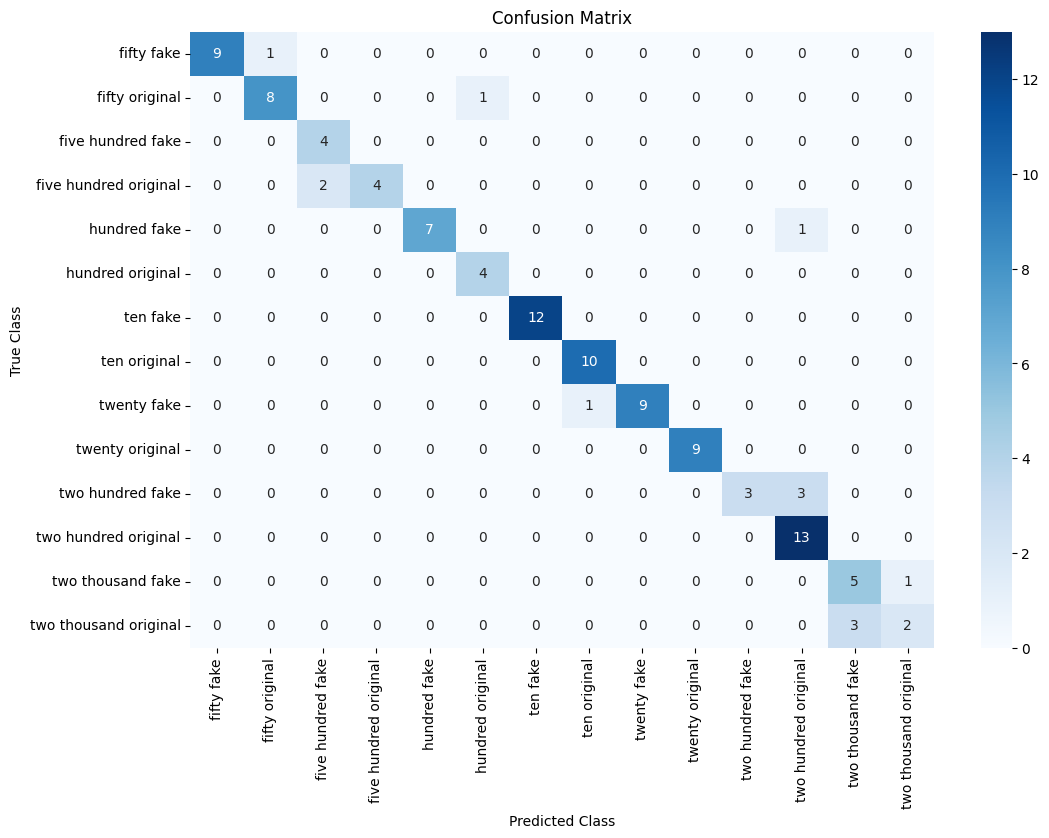

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Evaluation Function for Metrics Calculation
def evaluate_model_metrics(model, data_loader, labels):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, label_batch in data_loader:
            images = images.to(device)
            label_batch = label_batch.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())

            if label_batch.dim() == 0:  # Handle 0-dim tensor case
                all_labels.append(label_batch.item())
            else:
                all_labels.extend(label_batch.cpu().numpy())

    # Calculate Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, labels=range(len(labels)), target_names=labels))

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds, labels=range(len(labels)))
    plt.figure(figsize=(12, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

# Evaluate on Validation Set
print("Validation Set Evaluation:")
evaluate_model_metrics(model, val_loader, class_names)

# Evaluate on Test Set
# print("Test Set Evaluation:")
# evaluate_model_metrics(model, test_loader, class_names)


In [ ]:
# Save the PyTorch model weights
torch.save(model.state_dict(), "/content/drive/MyDrive/PJT 2/fake currency using CNN/model_mobilenetv3_weights.pth")
print("Model weights saved successfully.")

# Save the entire PyTorch model
torch.save(model, "/content/drive/MyDrive/PJT 2/fake currency using CNN/full_model_mobilenetv3.pth")
print("Full model saved successfully.")


Model weights saved successfully.
Full model saved successfully.


**FLASK**

In [ ]:
#necessary packages
!pip install flask pyngrok torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models
from flask import Flask, render_template, request, send_from_directory
from PIL import Image
import numpy as np
from pyngrok import ngrok


app = Flask(__name__, template_folder='/content/drive/MyDrive/PJT 2/fake currency using CNN/templates')

# Define folders
UPLOAD_FOLDER = '/content/drive/MyDrive/PJT 2/fake currency using CNN/uploads'
os.makedirs(UPLOAD_FOLDER, exist_ok=True)

# Model path
model_path = '/content/drive/MyDrive/PJT 2/fake currency using CNN/best_model.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the trained PyTorch model
model = models.mobilenet_v3_large(pretrained=True)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 14)  # Adjusting the final layer for 14 classes
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()
print('✅ Model loaded successfully.')

# Image Preprocessing
transform = transforms.Compose([
    transforms.Resize((224,448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Label Names (Match this with your training data classes)
label_names = [
    'fifty fake', 'fifty original', 'five hundred fake', 'five hundred original',
    'hundred fake', 'hundred original', 'ten fake', 'ten original',
    'twenty fake', 'twenty original', 'two hundred fake', 'two hundred original',
    'two thousand fake', 'two thousand original'
]

# Predict & classify image
def classify(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.softmax(outputs, dim=1)
        prob, predicted_label_index = torch.max(probabilities, 1)
        label = label_names[predicted_label_index.item()]
        classified_prob = round(prob.item() * 100, 2)

    return label, classified_prob

# Home page
@app.route('/')
def home():
    return render_template('home2.html')

# Classify page
@app.route('/classify', methods=['POST', 'GET'])
def upload_file():
    if request.method == 'POST':
        if 'image' not in request.files:
            return 'No file uploaded', 400

        file = request.files['image']
        if file.filename == '':
            return 'No selected file', 400

        upload_image_path = os.path.join(UPLOAD_FOLDER, file.filename)
        file.save(upload_image_path)

        label, prob = classify(upload_image_path)

        return render_template('classify2.html', label=label, prob=prob, image_file_name=file.filename)
    return 'Invalid Request', 400

# Serve uploaded images
@app.route('/uploads/<filename>')
def send_file(filename):
    return send_from_directory(UPLOAD_FOLDER, filename)

# Run the app using pyngrok
if __name__ == '__main__':
    ngrok.set_auth_token('2ucG6F5qIjzOpAezBg7MV5lkknN_4DfWb1VXb2ygeoz6zMNyo')  # Add ngrok token here
    public_url = ngrok.connect(5000)
    print(f'Your app is running here: {public_url}')
    app.run(port=5000)




/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 122MB/s] 


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/PJT 2/fake currency using CNN/best_model.pth'

**STREAM LIT 1**